### Setup

In [2]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [3]:
from darts.models import TSMixerModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


In [4]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

### Configuration

In [5]:
NAME = 'tsmixer'

In [6]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
    likelihood=NegativeBinomialLikelihood(),
    pl_trainer_kwargs={
       "enable_progress_bar" : True,
       "enable_model_summary" : False,
       "accelerator" : "cpu",
       "callbacks" : [RichProgressBar(leave=True)]
    }
)

OPTIMIZER_DICT = {
    "Adam" : torch.optim.Adam,
    "AdamW" : torch.optim.AdamW,
    "SGD": torch.optim.SGD
}

In [7]:
sweep_configuration = {
    "name": f"{NAME}-expanding-window",
    "method": "random",
    "metric": {"goal": "minimize", "name": "WIS"},
    "parameters": {
        "model" : {"values" : [NAME]},
        "use_static_covariates" :  {"values" : [False]},
        "use_covariates" :  {"values" : [True, False]},
        "use_features" :  {"values" : [False]},
        "use_encoders" :  {"values" : [True, False]},
        "input_chunk_length" : {"values" : [8, 10, 12]},
        "hidden_size" : {"values" : [8, 16, 32, 64]},
        "ff_size" : {"values" : [8, 16, 32, 64]},
        "num_blocks" : {"values" : [4, 6, 8]},
        "dropout" : {"values" : [0, 0.05, 0.1, 0.2]}, # 0.05, 0.1, 0.2, 0.3, 0.5
        "norm_type"  : {"values" : ['TimeBatchNorm2d']}, # 'LayerNorm', 
        "batch_size" : {"values" : [8, 16, 32]},
        "n_epochs" : {"values" : [500, 1000, 1500]},
        "normalize_before" : {"values" : [False]},
        "activation" : {"values" : ["ReLU"]}, # "ReLU", "GELU", "LeakyReLU", "ELU"
        "optimizer" : {"values": ["AdamW"]}, # SGD, "Adam", 
        "optimizer_kwargs" : {
            "parameters": {
                "lr" : {"values" : [0.01, 0.005, 0.001, 0.0005]},
                "weight_decay" : {"values" : [0, 0.0001, 0.001, 0.01]}
            }
        }
    }
}

### Load data

In [8]:
def get_season_start(start_year):
    return pd.to_datetime(Week(start_year, 40, system="iso").enddate())

In [9]:
def get_season_end(start_year):
    return pd.to_datetime(Week(start_year + 1, 39, system="iso").enddate())

In [10]:
get_season_end(2023)

Timestamp('2024-09-29 00:00:00')

In [11]:
get_season_start(2024)

Timestamp('2024-10-06 00:00:00')

In [12]:
def train_validation_split(series, validation_year):
    validation_end = get_season_end(validation_year)
    train_end = get_season_end(validation_year - 1)

    ts_validation = series[:validation_end]
    ts_train = series[:train_end]
    
    return ts_train, ts_validation

In [13]:
targets, covariates = load_realtime_training_data()

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


In [14]:
targets_train, targets_validation = train_validation_split(targets, 2022)

<Axes: xlabel='date'>

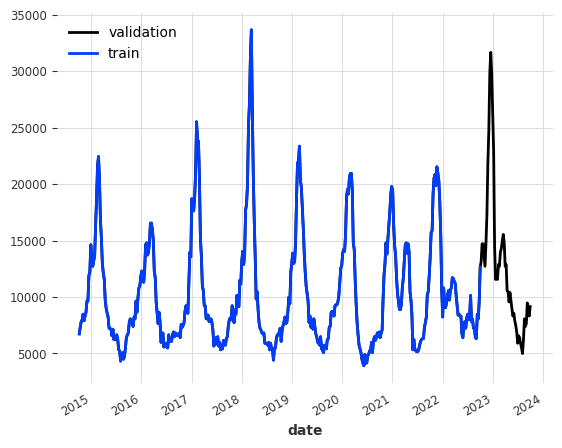

In [15]:
targets_validation['icosari-sari-DE'].plot(label='validation')
targets_train['icosari-sari-DE'].plot(label='train')

### Block CV

In [9]:
# Block CV
def objective(config):
    optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    
    model = TSMixerModel(
        input_chunk_length=config.input_chunk_length,
        hidden_size=config.hidden_size,
        ff_size=config.ff_size,
        num_blocks=config.num_blocks,
        dropout=config.dropout,
        norm_type=config.norm_type,
        batch_size=config.batch_size,
        n_epochs=config.n_epochs,
        normalize_before=config.normalize_before,
        activation=config.activation,
        optimizer_cls=optimizer,
        optimizer_kwargs={**config.optimizer_kwargs},
        use_static_covariates=config.use_static_covariates,
        
        **SHARED_ARGS
    )
    
    scores = []
    k=0
    for train, validation, cov in zip(targets_train, targets_validation, covariates):
        k+=1
        score = compute_validation_score(model, train, validation, cov if use_covariates else None, 
                                         HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS)
        scores.append(score)
        wandb.log({f'WIS_{k}' : score})
        # model.reset()?
            
    avg_score = np.mean(scores) # average across all validation periods
    std = np.std(scores)
    var = np.var(scores)
    
    wandb.log({'WIS_std' : std,
               'WIS_var' : var})

    return avg_score

### Simple validation

In [10]:
# Simple validation
def objective(config):
    optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    use_features = config.use_features
    use_encoders = config.use_encoders
    
    model = TSMixerModel(
        input_chunk_length=config.input_chunk_length,
        hidden_size=config.hidden_size,
        ff_size=config.ff_size,
        num_blocks=config.num_blocks,
        dropout=config.dropout,
        norm_type=config.norm_type,
        batch_size=config.batch_size,
        n_epochs=config.n_epochs,
        normalize_before=config.normalize_before,
        activation=config.activation,
        optimizer_cls=optimizer,
        optimizer_kwargs={**config.optimizer_kwargs},
        use_static_covariates=config.use_static_covariates,
        add_encoders=ENCODERS if use_encoders else None,
        
        **SHARED_ARGS
    )
    
    train = targets_train
    validation = targets_validation
    cov = covariates
    
    if use_features:
        ts_features = load_features(lag=8)
        cov = cov.slice_intersect(ts_features) # features start a bit later because of rolling window
        ts_features = ts_features.slice_intersect(cov) # features are longer because they cover the whole period until now
    
    score = compute_validation_score(model, train, validation, cov if use_covariates else None, 
                                     HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS)

    return score

### Multiple runs

In [11]:
RANDOM_SEEDS = [1, 2, 3]

In [12]:
# Multiple runs
def objective(config):
    optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    use_features = config.use_features
    use_encoders = config.use_encoders
    
    model = TSMixerModel(
        input_chunk_length=config.input_chunk_length,
        hidden_size=config.hidden_size,
        ff_size=config.ff_size,
        num_blocks=config.num_blocks,
        dropout=config.dropout,
        norm_type=config.norm_type,
        batch_size=config.batch_size,
        n_epochs=config.n_epochs,
        normalize_before=config.normalize_before,
        activation=config.activation,
        optimizer_cls=optimizer,
        optimizer_kwargs={**config.optimizer_kwargs},
        use_static_covariates=config.use_static_covariates,
        add_encoders=ENCODERS if use_encoders else None,
        
        **SHARED_ARGS
    )
    
    train = targets_train
    validation = targets_validation
    cov = covariates
    
    if use_features:
        ts_features = load_features(lag=8)
        cov = cov.slice_intersect(ts_features) # features start a bit later because of rolling window
        ts_features = ts_features.slice_intersect(cov) # features are longer because they cover the whole period until now
    
    
    scores = []
    for seed in RANDOM_SEEDS:
        model.model_params['random_state'] = seed
        score = compute_validation_score(model, train, validation, cov if use_covariates else None, 
                                         HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS)
        scores.append(score)
        wandb.log({f'WIS_{seed}' : score})
        model.reset_model()
            
    avg_score = np.mean(scores) # average across all runs
    std = np.std(scores)
    
    wandb.log({'WIS_std' : std})

    return avg_score

### Expanding window

In [16]:
VALIDATION_YEARS = [2018, 2019, 2022, 2023]

In [17]:
# Expanding window
def objective(config):
    optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    use_features = config.use_features
    use_encoders = config.use_encoders
    
    model = TSMixerModel(
        input_chunk_length=config.input_chunk_length,
        hidden_size=config.hidden_size,
        ff_size=config.ff_size,
        num_blocks=config.num_blocks,
        dropout=config.dropout,
        norm_type=config.norm_type,
        batch_size=config.batch_size,
        n_epochs=config.n_epochs,
        normalize_before=config.normalize_before,
        activation=config.activation,
        optimizer_cls=optimizer,
        optimizer_kwargs={**config.optimizer_kwargs},
        use_static_covariates=config.use_static_covariates,
        add_encoders=ENCODERS if use_encoders else None,
        
        **SHARED_ARGS
    )
    
    
    scores = []
    for validation_year in VALIDATION_YEARS:
        targets_train, targets_validation = train_validation_split(targets, validation_year)
        score = compute_validation_score(model, targets_train, targets_validation, covariates if use_covariates else None, 
                                         HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS)
        scores.append(score)
        wandb.log({f'WIS_{validation_year}' : score})
        model.reset_model()
            
    avg_score = np.mean(scores) # average across all runs
    std = np.std(scores)
    
    wandb.log({'WIS_std' : std})

    return avg_score

### Run tuning

In [18]:
def main():
    run = wandb.init()
    score = objective(wandb.config)
    wandb.log({"WIS": score})
    run.finish()

In [18]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="realtime-tsmixer-expanding-window")

Create sweep with ID: 7gxhk8q9
Sweep URL: https://wandb.ai/dwolffram-karlsruhe-institute-of-technology/realtime-tsmixer-expanding-window/sweeps/7gxhk8q9


In [ ]:
wandb.agent(sweep_id, function=main, count=1000)

Epoch 455/999 ━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━ 7/15 0:00:00 • 0:00:01 36.13it/s train_loss: 7.503

In [ ]:
wandb.agent(sweep_id='7gxhk8q9', function=main, count=1000, project="realtime-tsmixer-expanding-window")

Epoch 929/999 ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/32 0:00:00 • 0:00:03 10.86it/s train_loss: 6.676